In [43]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score

In [44]:
# Notebook params
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams.update({'font.size': 15})

In [3]:
org_data = pd.read_csv('source/data.csv')

print('Dataset shape:',org_data.shape)
with pd.option_context('display.max_columns', None):
    display(org_data.head())

Dataset shape: (10000, 21)


,id,age,gender,race,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,DUIs,past_accidents,outcome,telematic_score,monthly_mileage
0,569520,65+,female,majority,0-9y,high school,high,0.629027,True,after 2015,False,True,10238,12000.0,sedan,0,0,0,False,37.454012,1000.000000
1,750365,16-25,male,majority,0-9y,none,very low,0.357757,False,before 2015,False,False,10238,16000.0,sedan,0,0,0,True,95.071431,1333.333333
2,199901,16-25,female,majority,0-9y,high school,low,0.493146,True,before 2015,False,False,10238,11000.0,sedan,0,0,0,False,73.199394,916.666667
3,478866,16-25,male,majority,0-9y,university,low,0.206013,True,before 2015,False,True,32765,11000.0,sedan,0,0,0,False,59.865848,916.666667
4,731664,26-39,male,majority,10-19y,none,low,0.388366,True,before 2015,False,False,32765,12000.0,sedan,2,0,1,True,15.601864,1000.000000


#### Exploratory Data Analysis

In [19]:
org_data.describe()

,id,credit_score,postal_code,annual_mileage,speeding_violations,DUIs,past_accidents,telematic_score,monthly_mileage
count,10000.000000,9018.000000,10000.000000,9043.000000,10000.000000,10000.00000,10000.000000,10000.000000,9043.000000
mean,500521.906800,0.515813,19864.548400,11697.003207,1.482900,0.23920,1.056300,49.415956,974.750267
std,290030.768758,0.137688,18915.613855,2818.434528,2.241966,0.55499,1.652454,28.763013,234.869544
min,101.000000,0.053358,10238.000000,2000.000000,0.000000,0.00000,0.000000,0.001163,166.666667
25%,249638.500000,0.417191,10238.000000,10000.000000,0.000000,0.00000,0.000000,24.632887,833.333333
50%,501777.000000,0.525033,10238.000000,12000.000000,0.000000,0.00000,0.000000,49.252862,1000.000000
75%,753974.500000,0.618312,32765.000000,14000.000000,2.000000,0.00000,2.000000,74.000635,1166.666667
max,999976.000000,0.960819,92101.000000,22000.000000,22.000000,6.00000,15.000000,99.971767,1833.333333


In [4]:
# 1. What proportion of customers with a credit score below 0.2 made a claim in the last year?
small_credit = org_data[org_data.credit_score<0.2]
small_credit_claim = small_credit['outcome'].value_counts(normalize=True).to_frame().T[True][0]
print('{} percent of customers with a credit score below 0.2 made a claim last year'.format(round(small_credit_claim*100)))

60 percent of customers with a credit score below 0.2 made a claim last year


Text(0, 0.5, 'Number of cases')

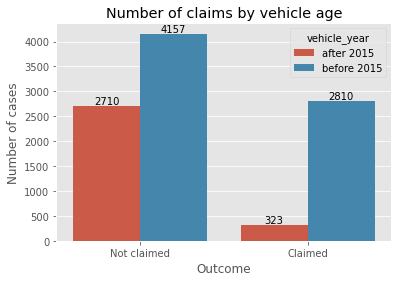

In [5]:
# Main points visualization
plt.rcParams["figure.figsize"] = (15,10)

org_data['Outcome'] = np.where(org_data['outcome'], 'Claimed', 'Not claimed')
ax = sns.countplot(data=org_data, x='Outcome', hue='vehicle_year')

for bars in ax.containers:
    ax.bar_label(bars)
plt.title('Number of claims by vehicle age')
plt.xlabel('Outcome')
plt.ylabel('Number of cases')

The plot presents number of claims made and not by available vehicle age.

For over 40% of vehicles older than 2015 a claim has been made. In the case of younger vehicles this is just ~10%. This could be due to various reasons, like worse equipment on the older cars. Younger vehicles have overall better systems, like traction control or special sensors for keeping a car in line. As the risk of making a claim is significantly higher for the older vehicles, their premiums should be higher as well.

Text(0, 0.5, 'Number of cases')

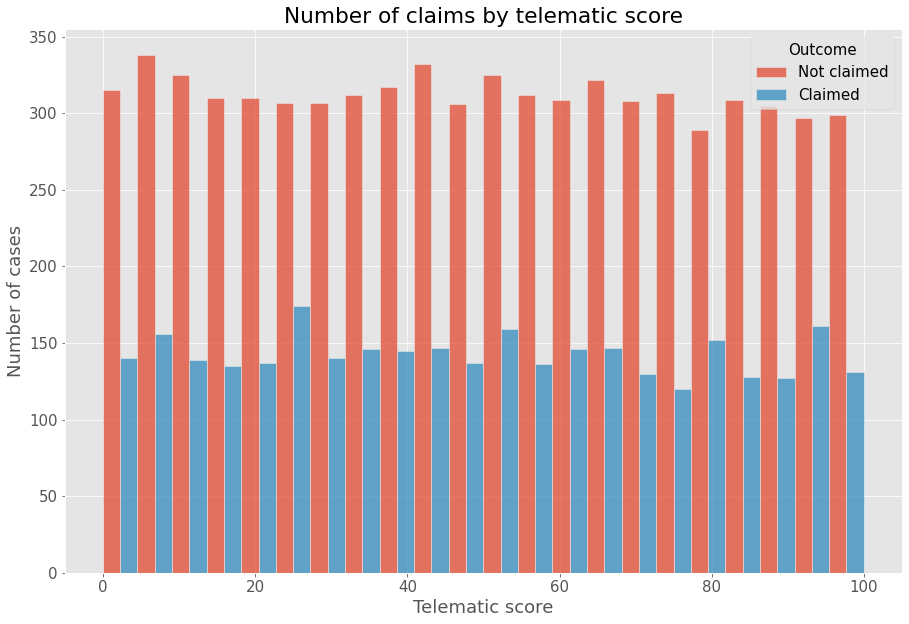

In [65]:
ax = sns.histplot(data=org_data, x='telematic_score', hue='Outcome',multiple='dodge')

plt.title('Number of claims by telematic score')
plt.xlabel('Telematic score')
plt.ylabel('Number of cases')

Interestingly, the telematic score does not seem to have any effect on the claims. For vast majority of scores the claims oscillate around 30% of all cases. That would suggest, that the driving style does not impact the accidents. This seems counter-intuitive, but it can be explained. One possibility would be malfunctioning or bad telematics devices. If that is the case, the algorithm in these devices should be adjusted or replaced. Second possibility is the randomization of provided data, in which case it is not possible to say more until more records are provided.  

Text(0, 0.5, 'Number of cases')

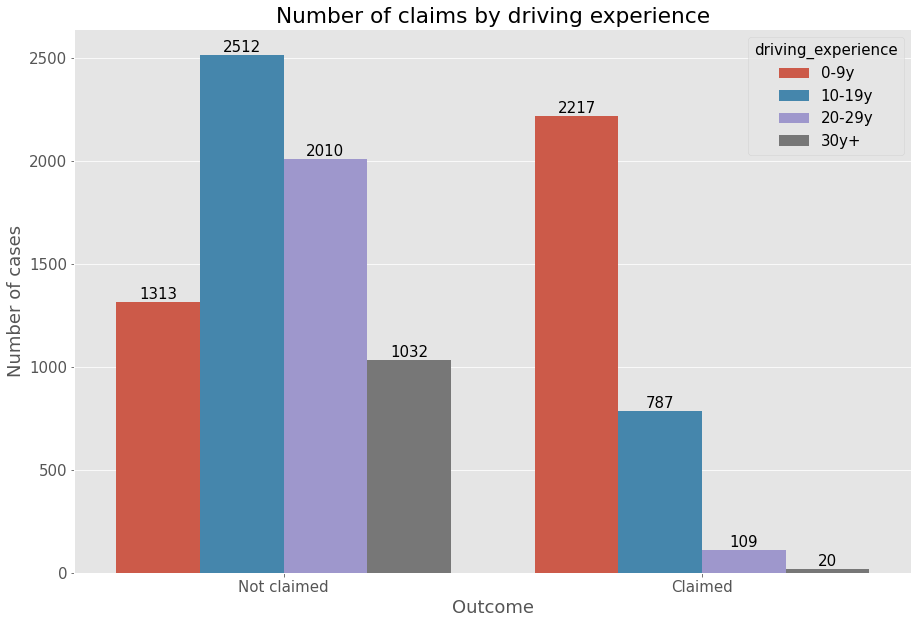

In [67]:
ax = sns.countplot(data=org_data, x='Outcome', hue='driving_experience')

for bars in ax.containers:
    ax.bar_label(bars)
plt.title('Number of claims by driving experience')
plt.xlabel('Outcome')
plt.ylabel('Number of cases')

Not only a clear majority of claims (70%) is done by drivers with short experience (<9 years), but also over 60% of all of these drivers made a claim in the last year. This shows, that young drivers (in terms of experience, not age) are more risky for a company and their premium should be higher.

#### Modelling

In [ ]:
1. check if features are istotne
OHE
2. check correlations
3. PCA if needed
4. search for the best parameters
5. RF
6. XGBoost


1. srpawdzic feature importance 
2. zupdatowac data przez wyrzucenie kolumn z org_data
3. korelcje? 
4. zrobić  train_test_split
5. zrobic OHE
6. wysokie korelacje -> zrobic PCA
7. wytrenowac model
8. wytrenowac XGB
9. opisac 

In [18]:
# switching label to 1-0 
org_data['outcome'] = np.where(org_data['outcome'], 1, 0)
data = org_data.drop(['id', 'Outcome'], axis = 1) #!!!!!

In [19]:
org_data

,id,age,gender,race,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,...,postal_code,annual_mileage,vehicle_type,speeding_violations,DUIs,past_accidents,outcome,telematic_score,monthly_mileage,Outcome
0,569520,65+,female,majority,0-9y,high school,high,0.629027,True,after 2015,...,10238,12000.0,sedan,0,0,0,0,37.454012,1000.000000,0
1,750365,16-25,male,majority,0-9y,none,very low,0.357757,False,before 2015,...,10238,16000.0,sedan,0,0,0,1,95.071431,1333.333333,1
2,199901,16-25,female,majority,0-9y,high school,low,0.493146,True,before 2015,...,10238,11000.0,sedan,0,0,0,0,73.199394,916.666667,0
3,478866,16-25,male,majority,0-9y,university,low,0.206013,True,before 2015,...,32765,11000.0,sedan,0,0,0,0,59.865848,916.666667,0
4,731664,26-39,male,majority,10-19y,none,low,0.388366,True,before 2015,...,32765,12000.0,sedan,2,0,1,1,15.601864,1000.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,323164,26-39,female,majority,10-19y,university,high,0.582787,True,before 2015,...,10238,16000.0,sedan,0,0,1,0,85.765599,1333.333333,0
9996,910346,26-39,female,majority,10-19y,none,medium,0.522231,True,after 2015,...,32765,NaN,sedan,1,0,0,0,89.750884,NaN,0
9997,468409,26-39,male,majority,0-9y,high school,medium,0.470940,True,before 2015,...,10238,14000.0,sedan,0,0,0,0,94.670792,1166.666667,0
9998,903459,26-39,female,majority,10-19y,high school,very low,0.364185,False,before 2015,...,10238,13000.0,sedan,2,0,1,1,39.748799,1083.333333,1


In [27]:
org_data.isna().sum()
# 

# with pd.option_context('display.max_columns', None):
#     display(org_data[org_data.credit_score.isnull()].head())

id                       0
age                      0
gender                   0
race                     0
driving_experience       0
education                0
income                   0
credit_score           982
vehicle_ownership        0
vehicle_year             0
married                  0
children                 0
postal_code              0
annual_mileage         957
vehicle_type             0
speeding_violations      0
DUIs                     0
past_accidents           0
outcome                  0
telematic_score          0
monthly_mileage        957
Outcome                  0
dtype: int64

There are three column with missing values in the dataset, with ~1900 unique rows with nulls. There are three ways they can be approached:
- by dropping these rows. By decreasing the amount of available data for modelling, less information can be provided for models, but sometimes it might be the only way;
- by imputing missing values. Imputation allows to find an approximation of the missing observation, which then allows using rows with nulls. This is useful if such row contains valuable information which should be provided into the model, if the missing value is easy to predict or simply if there are many similar rows. However, wrong approach to imputation might highly disrupt final results; 
- by not including columns with missing information in further steps, if a column is proven to be unuseful.

A. IF COLS NOT RELEVANT THROUGH IMPORTANCE CHECK - 3rd option
B. IF RELEVANT - EXPLAIN IT'S POC and 1st option

In [36]:
print(org_data.columns)
org_data.dtypes

Index(['id', 'age', 'gender', 'race', 'driving_experience', 'education',
       'income', 'credit_score', 'vehicle_ownership', 'vehicle_year',
       'married', 'children', 'postal_code', 'annual_mileage', 'vehicle_type',
       'speeding_violations', 'DUIs', 'past_accidents', 'outcome',
       'telematic_score', 'monthly_mileage', 'Outcome'],
      dtype='object')


id                       int64
age                     object
gender                  object
race                    object
driving_experience      object
education               object
income                  object
credit_score           float64
vehicle_ownership         bool
vehicle_year            object
married                   bool
children                  bool
postal_code              int64
annual_mileage         float64
vehicle_type            object
speeding_violations      int64
DUIs                     int64
past_accidents           int64
outcome                  int64
telematic_score        float64
monthly_mileage        float64
Outcome                  int64
dtype: object

<ipython-input-42-7745168f926d>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(org_data.corr(), annot=True)


<AxesSubplot: >

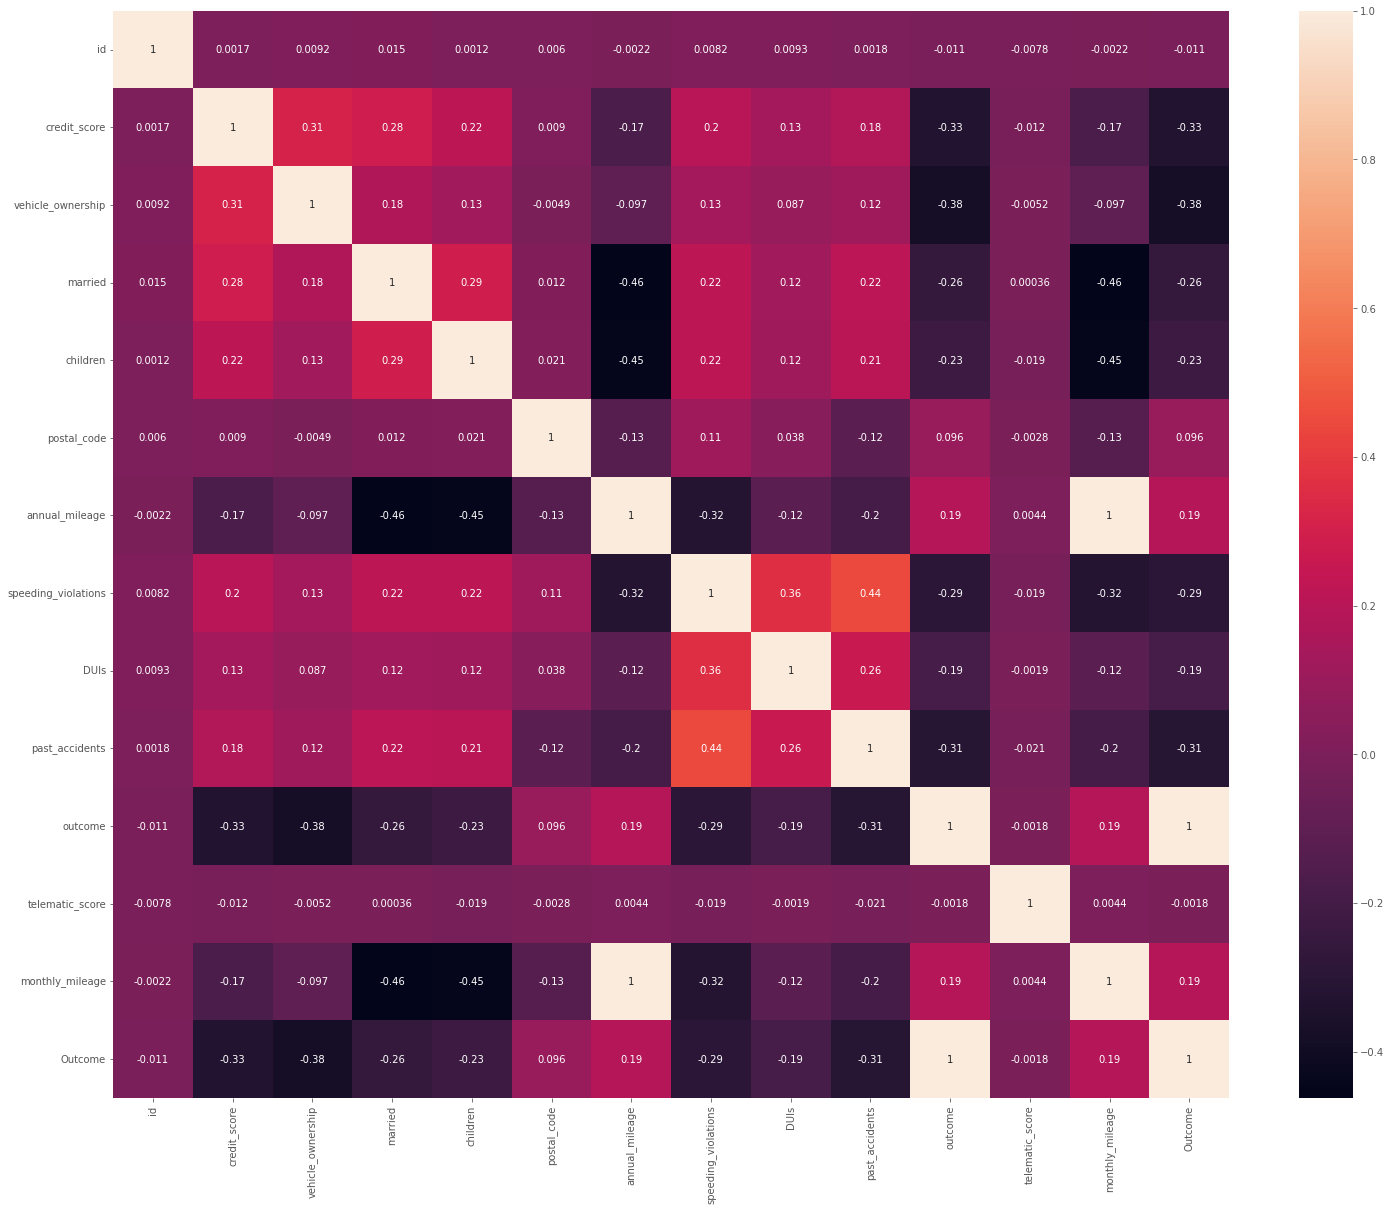

In [42]:
plt.rcParams["figure.figsize"] = (25,20)
sns.heatmap(org_data.corr(), annot=True)

In [ ]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split()

In [32]:
# One Hot Encoding

ohe = OneHotEncoder()
a = ohe.fit(org_data)
a.categories_

[array([   101,    125,    166, ..., 999856, 999962, 999976]),
 array(['16-25', '26-39', '40-64', '65+'], dtype=object),
 array(['female', 'male'], dtype=object),
 array(['majority', 'minority'], dtype=object),
 array(['0-9y', '10-19y', '20-29y', '30y+'], dtype=object),
 array(['high school', 'none', 'university'], dtype=object),
 array(['high', 'low', 'medium', 'very low'], dtype=object),
 array([0.05335755, 0.06086662, 0.06481035, ..., 0.91588318, 0.96081883,
               nan]),
 array([False,  True]),
 array(['after 2015', 'before 2015'], dtype=object),
 array([False,  True]),
 array([False,  True]),
 array([10238, 21217, 32765, 92101]),
 array([ 2000.,  3000.,  4000.,  5000.,  6000.,  7000.,  8000.,  9000.,
        10000., 11000., 12000., 13000., 14000., 15000., 16000., 17000.,
        18000., 19000., 20000., 21000., 22000.,    nan]),
 array(['sedan', 'sports car'], dtype=object),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 22])